In [1]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import time
import json
from datetime import datetime
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from HSI_class import HSI
import zeroPadding
import augmentation as aug
import createSample as CS

start_time = time.time()

# Check if GPU is available
print("GPU Available:", torch.cuda.is_available())

# If available, print the GPU name
if torch.cuda.is_available():
    print("GPU Name:", torch.cuda.get_device_name(0))

seeded_run = True
seed = 10
sample_per_class = 5
num_per_category_augment_1 = 10
num_per_category_augment_2 = 10
epochs = 200

batch_size =40
test_size = 0.5

random_indices = 0

GPU Available: True
GPU Name: NVIDIA GeForce RTX 4080 SUPER


In [2]:
def set_seed(seed):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False  # Might slow down training, but ensures determinism

    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)

if seeded_run:
    set_seed(seed)
    print("seed has been set")

seed has been set


In [3]:
dataset_path = r"D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets"

datasets = []

i = 0
for filename in os.listdir(dataset_path):
    if i>9:
        break
    file_path = os.path.join(dataset_path, filename)
    if os.path.isfile(file_path):  # Check if it's a file
        print(f"Processing file: {file_path}")
        hsi = HSI(file_path)
        datasets.append(hsi)
    i += 1

Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM01.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM02.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM03.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM04.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM05.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM06.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM07.mat
Processing file: D:\FathanAbi\tugas-akhir-model-deteksi-tumpahan-minyakl\Hyperspectral oil spill detection datasets\GM08.mat


In [4]:
def testWithDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    test_gt = hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {test_gt.shape}")

    indices0 = np.argwhere(test_gt == 0)
    indices1 = np.argwhere(test_gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    num_samples = 50

    random_indices0 = indices0[np.random.choice(len(indices0), num_samples, replace=False)]
    random_indices1 = indices1[np.random.choice(len(indices1), num_samples, replace=False)]

    test_indices = np.vstack((random_indices0, random_indices1))

    print(test_indices.shape)

    return test_indices, test_gt, matrix

In [5]:
hsi_ = datasets[0]
patch_size = 9

indices_0 = []
indices_1 = []

print(f"random: {random_indices}")
random_indices = 1
if random_indices:
    print("generating random sample")
    selected_patch_0, selected_patch_1, indices_0, indices_1 = CS.createSample(hsi_, patch_size, sample_per_class)
else:
    print("using generated indices")
    indices_0 = [(np.int64(188), np.int64(124)), (np.int64(523), np.int64(150)), (np.int64(1003), np.int64(474)), (np.int64(616), np.int64(508)), (np.int64(905), np.int64(552))]
    indices_1 = [(np.int64(106), np.int64(606)), (np.int64(297), np.int64(468)), (np.int64(926), np.int64(35)), (np.int64(536), np.int64(519)), (np.int64(508), np.int64(442))]

    selected_patch_0, selected_patch_1 = CS.getSample(hsi_, patch_size, sample_per_class, indices_0, indices_1)


i =0
half_patch = patch_size // 2


indices = indices_0 +  indices_1

# Concatenating along axis 0
x_train = np.concatenate((selected_patch_0, selected_patch_1), )

y_train = np.array([])

gt = hsi_.gt
for indice in indices:
    # print(gt[indice[0]][indice[1]])
    y_train = np.append(y_train, gt[indice[0]][indice[1]])

count = np.count_nonzero(y_train == 0)  # Count elements equal to 0
print(f'number of element equal 0 {count}')

count = np.count_nonzero(y_train == 1)  # Count elements equal to 1
print(f'number of element equal 1 {count}')



# Print shape to verify
print(f"x_train shape: {x_train.shape}")  # Expected output: (10, 9, 9, 224)
print(f"y_train shape: {y_train.shape}") 


random: 0
generating random sample
hsi shape
(1243, 684, 224)
creating 5 Randomly chosen 0 indices:
creating 5 Randomly chosen 1 indices:
indices 0 used: [(np.int64(910), np.int64(192)), (np.int64(51), np.int64(255)), (np.int64(689), np.int64(202)), (np.int64(772), np.int64(547)), (np.int64(920), np.int64(471))]
indices 1 used: [(np.int64(22), np.int64(455)), (np.int64(170), np.int64(145)), (np.int64(410), np.int64(233)), (np.int64(1055), np.int64(123)), (np.int64(469), np.int64(582))]
number of element equal 0 5
number of element equal 1 5
x_train shape: (10, 9, 9, 224)
y_train shape: (10,)


In [6]:
i =1
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])
i =4
half_patch = patch_size // 2
print(hsi_.img[indices_0[i][0]][indices_0[i][1]])
print(selected_patch_0[i][half_patch][half_patch])

print(hsi_.img[indices_1[i][0]][indices_1[i][1]])
print(selected_patch_1[i][half_patch][half_patch])

[-219 -372  361  395  442  586  641  667  632  594  559  517  484  453
  432  402  375  347  324  297  275  250  230  202  176  163  153  142
  137  125  124  116  116  111   99   86   73   65   54   19   39   47
   59   20   40   41   37   35   33   17   19   23   38   34   35   27
   28   11    1   -6   -5  -13 -184  -77    5    4   19   25   26   29
   31   25   27   27   28   23   18   15    4  -26 -217 -248 -115 -122
  -43   -5    2    0    4    0    6   12   17   17   22   22   23   22
   36   17   18    7    4   15   -5  -31    0    0    0    0    0    0
    0    0  -41 -185  -52  -35  -86  -44   -6    6   12   12   22   22
   20   20   22   25   27   26   24   21   20   24   27   16   23   28
   25   29   22   18   12   17   14    5    7   -1    5  120    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
  -66  -65    0    0    1   -9    2  -15   13   14   17   18   15   12
   18   14   17   22   21   18   17   20   27   10   11   13   12   16
    8 

In [7]:
n_category = 2
band_size = 224

data_augment1, label_augment1 = aug.Augment_data(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_1)

data_augment2, label_augment2 = aug.Augment_data2(x_train, y_train, n_category, patch_size, band_size, num_per_category_augment_2)

print(f"hasil augmentasi 1 shape: {data_augment1.shape}")
print(f"label augmentai 1 shape: {label_augment1.shape}")

print(f"hasil augmentasi 2 shape: {data_augment2.shape}")
print(f"label augmentasi 2 shape: {label_augment2.shape}")

print(label_augment1)
print(label_augment2)

data_augment = np.concatenate((data_augment1, data_augment2))
label_augment = np.concatenate((label_augment1, label_augment2))

print(f"hasil augmentasi gabungan untuk training: {data_augment.shape}")
print(f"label augmentasi gabungan: {label_augment.shape}")

# print(label_augment)

# Count occurrences of each unique element
counts = np.bincount(label_augment)

# Print results
for i, count in enumerate(counts):
    print(f"Element {i} occurs {count} times.")

hasil augmentasi 1 shape: (20, 9, 9, 224)
label augmentai 1 shape: (20,)
hasil augmentasi 2 shape: (20, 9, 9, 224)
label augmentasi 2 shape: (20,)
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
[0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1]
hasil augmentasi gabungan untuk training: (40, 9, 9, 224)
label augmentasi gabungan: (40,)
Element 0 occurs 20 times.
Element 1 occurs 20 times.


In [8]:
print(data_augment.shape)
print(label_augment.shape)

x_data = data_augment 
y_labels = label_augment

x_data = torch.tensor(x_data)
x_data = x_data.to(torch.float32)
x_data = x_data.permute(0, 3, 1, 2)
print(f"X_train shape: {x_data.shape}")


features_np = x_data.numpy() 
print(features_np.shape)

(40, 9, 9, 224)
(40,)
X_train shape: torch.Size([40, 224, 9, 9])
(40, 224, 9, 9)


In [9]:
X = features_np
y = y_labels
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=test_size, random_state=seed)

print(y_train)
print(y_val)

[0 1 1 0 0 1 1 1 1 0 0 1 1 0 0 0 0 1 1 0]
[0 0 1 1 1 1 0 0 1 1 0 0 0 0 0 1 0 1 1 1]


In [10]:
class HybridSN_Binary(nn.Module):
    def __init__(self, input_channels=1, spectral_bands=224, height=9, width=9):
        super(HybridSN_Binary, self).__init__()

        self.conv3d_1 = nn.Conv3d(input_channels, 8, kernel_size=(3, 3, 7), padding=(1, 1, 3))
        self.conv3d_2 = nn.Conv3d(8, 16, kernel_size=(3, 3, 5), padding=(1, 1, 2))
        self.conv3d_3 = nn.Conv3d(16, 32, kernel_size=(3, 3, 3), padding=(1, 1, 1))

        self.conv2d = nn.Conv2d(32 * spectral_bands, 64, kernel_size=(3, 3), padding=1)

        self.flattened_size = 64 * height * width

        self.fc1 = nn.Linear(self.flattened_size, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)  # single output neuron for binary classification

    def forward(self, x):
        x = F.relu(self.conv3d_1(x))  # [B, 8, 224, 9, 9]
        x = F.relu(self.conv3d_2(x))  # [B, 16, 224, 9, 9]
        x = F.relu(self.conv3d_3(x))  # [B, 32, 224, 9, 9]

        # Merge spectral and channel dimensions: [B, 32 * 224, 9, 9]
        B, C, D, H, W = x.shape
        x = x.view(B, C * D, H, W)

        x = F.relu(self.conv2d(x))  # Conv2d now expects input with more channels

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)  # Output logit

        return x.squeeze(1)  # Output shape: (B,)



In [11]:

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

print(X_train_tensor.shape)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor )
train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

if seeded_run:
    g = torch.Generator()
    g.manual_seed(seed)

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=False,  # set to True if needed
        num_workers=0,
        pin_memory=True,
        drop_last=False,
        generator=g
    )
    print("generate data loader using seed")
else:
    train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)

input_channels = X_train_tensor.shape[1]
print(input_channels)

torch.Size([20, 1, 224, 9, 9])
generate data loader using seed
1


In [12]:


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = HybridSN_Binary(input_channels=1, spectral_bands=224, height=9, width=9)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

for epoch in range(100):
    model.train()
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        labels = labels.squeeze(1)
        # print(labels.shape)
        # print(labels)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}/100, Loss: {loss.item():.4f}")


Epoch 1/100, Loss: 31.5194
Epoch 2/100, Loss: 832.5820
Epoch 3/100, Loss: 686.7418
Epoch 4/100, Loss: 59.8239
Epoch 5/100, Loss: 63.0861
Epoch 6/100, Loss: 27.8633
Epoch 7/100, Loss: 26.5636
Epoch 8/100, Loss: 24.9379
Epoch 9/100, Loss: 24.7849
Epoch 10/100, Loss: 26.9122
Epoch 11/100, Loss: 24.1108
Epoch 12/100, Loss: 24.4963
Epoch 13/100, Loss: 23.7524
Epoch 14/100, Loss: 23.5839
Epoch 15/100, Loss: 23.3823
Epoch 16/100, Loss: 23.4144
Epoch 17/100, Loss: 23.1447
Epoch 18/100, Loss: 23.1625
Epoch 19/100, Loss: 23.1032
Epoch 20/100, Loss: 23.1499
Epoch 21/100, Loss: 23.0667
Epoch 22/100, Loss: 23.0941
Epoch 23/100, Loss: 23.0817
Epoch 24/100, Loss: 23.0405
Epoch 25/100, Loss: 23.0683
Epoch 26/100, Loss: 23.0451
Epoch 27/100, Loss: 23.0397
Epoch 28/100, Loss: 23.0496
Epoch 29/100, Loss: 23.0366
Epoch 30/100, Loss: 23.0397
Epoch 31/100, Loss: 23.0377
Epoch 32/100, Loss: 23.0372
Epoch 33/100, Loss: 23.0331
Epoch 34/100, Loss: 23.0310
Epoch 35/100, Loss: 23.0376
Epoch 36/100, Loss: 23.0313

In [13]:
X_val_tensor   = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
y_val_tensor   = torch.tensor(y_val, dtype=torch.float32).unsqueeze(1)

In [14]:
model.eval()
with torch.no_grad():
    val_outputs = model(X_val_tensor.to(device)).cpu().squeeze()
    val_probs = torch.sigmoid(val_outputs)
    val_preds = (val_probs >= 0.5).int().numpy()

# Accuracy
acc = accuracy_score(y_val, val_preds)
print(f"Validation Accuracy: {acc:.4f}")

# Print predictions and probabilities
for i, (pred, prob) in enumerate(zip(val_preds, val_probs)):
    print(f"Sample {i}: Predicted = {pred}, Prob(class 1) = {prob:.4f}")


Validation Accuracy: 0.9000
Sample 0: Predicted = 0, Prob(class 1) = 0.0000
Sample 1: Predicted = 0, Prob(class 1) = 0.0000
Sample 2: Predicted = 1, Prob(class 1) = 0.5816
Sample 3: Predicted = 1, Prob(class 1) = 0.5302
Sample 4: Predicted = 1, Prob(class 1) = 0.5795
Sample 5: Predicted = 0, Prob(class 1) = 0.1458
Sample 6: Predicted = 0, Prob(class 1) = 0.0000
Sample 7: Predicted = 0, Prob(class 1) = 0.0000
Sample 8: Predicted = 1, Prob(class 1) = 0.5309
Sample 9: Predicted = 1, Prob(class 1) = 0.5252
Sample 10: Predicted = 0, Prob(class 1) = 0.0000
Sample 11: Predicted = 0, Prob(class 1) = 0.0000
Sample 12: Predicted = 0, Prob(class 1) = 0.0000
Sample 13: Predicted = 0, Prob(class 1) = 0.0000
Sample 14: Predicted = 0, Prob(class 1) = 0.0000
Sample 15: Predicted = 1, Prob(class 1) = 0.5813
Sample 16: Predicted = 0, Prob(class 1) = 0.0000
Sample 17: Predicted = 1, Prob(class 1) = 0.5334
Sample 18: Predicted = 0, Prob(class 1) = 0.3363
Sample 19: Predicted = 1, Prob(class 1) = 0.5299


In [15]:
def predict_batch_whole(model, batch_input, device):
    batch_input = batch_input.unsqueeze(1).to(device)
    # print(batch_input.shape)
    with torch.no_grad():  # Disable gradient computation
        val_outputs = model(batch_input).cpu()  # shape (B,)
        val_probs = torch.sigmoid(val_outputs)              # convert logits to probabilities
        val_preds = (val_probs >= 0.5).int().numpy()

    return val_preds, val_probs

In [16]:
def testWithWholeDataset(n): 
    hsi_test = datasets[n]

    test_img = hsi_test.img
    gt= hsi_test.gt

    patch_size = 9
    half_patch = patch_size // 2

    height = test_img.shape[0]
    width = test_img.shape[1]

    matrix=zeroPadding.zeroPadding_3D(test_img,half_patch) #add 0 in every side of the data
    print(f"img shape: {test_img.shape}")
    print(f"img shape after padding {matrix.shape}")
    print(f"number of pixel {width * height}")

    print(f"ground truth shape: {gt.shape}")

    indices0 = np.argwhere(gt == 0)
    indices1 = np.argwhere(gt == 1)

    print(f"indices = 0 shape: {indices0.shape}")
    print(f"indices = 1 shape: {indices1.shape}")

    return matrix, gt, indices0.shape, indices1.shape

In [17]:
class PatchDataset(Dataset):
    def __init__(self, matrix, gt, half_patch, expected_shape):
        self.matrix = matrix
        self.gt = gt
        self.half_patch = half_patch
        self.expected_shape = expected_shape
        self.size_x, self.size_y = matrix.shape[0], matrix.shape[1]
        self.valid_coords = [
            (x, y)
            for x in range(half_patch, self.size_x - half_patch)
            for y in range(half_patch, self.size_y - half_patch)
        ]

    def __len__(self):
        return len(self.valid_coords)

    def __getitem__(self, idx):
        x, y = self.valid_coords[idx]
        true_label = self.gt[x - self.half_patch, y - self.half_patch]

        selected_rows = self.matrix[x- self.half_patch:x + 2 * self.half_patch + 1 - self.half_patch, :]
        testing_patch = selected_rows[:, y - self.half_patch:y + 2 * self.half_patch + 1 - self.half_patch]

        # Verify patch size
        if testing_patch.shape != self.expected_shape:
            raise ValueError(f"Patch at ({x},{y}) has wrong shape {testing_patch.shape}")

        patch_tensor = torch.tensor(testing_patch, dtype=torch.float32)
        patch_tensor = patch_tensor.permute(2, 0, 1)  # (C, H, W)

        return patch_tensor, true_label, x, y  # Also return (x, y) for positioning later

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

scores = []
groundtruth = []
prediction = []
y_probs = []


timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
os.makedirs(f"predictions/{timestamp}", exist_ok=True)
for dataset in range(len(datasets)):

    score = []
    patch_size = 9
    half_patch = patch_size // 2

    data_sampler = None
    batch_size = 64

    correct0 = 0
    correct1 = 0
    matrix = []
    gt = []
    expected_patch_shape = []
    dataset_patches = []
    data_loader = []
    patch_tensor = []
    true_label = [] 
    x = []
    y = []
    pred_matrix = []

    matrix, gt, indices_0_shape, indices_1_shape = testWithWholeDataset(dataset)
    print(indices_0_shape[0])
    print(indices_1_shape[0])

    expected_patch_shape = (2 * half_patch + 1, 2 * half_patch + 1, matrix.shape[2])
    dataset_patches = PatchDataset(matrix, gt, half_patch, expected_patch_shape)

    if seeded_run:
        g = torch.Generator()
        g.manual_seed(seed)

        data_loader = DataLoader(
            dataset_patches,
            batch_size=batch_size,
            shuffle=False,  # set to True if needed
            num_workers=0,
            pin_memory=True,
            drop_last=False,
            generator=g
        )
        print("generate data loader using seed")
    else:
        data_loader = DataLoader(dataset_patches, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True, drop_last=False)




    patch_tensor, true_label, x, y = next(iter(data_loader))

    print(patch_tensor.size())
    print(true_label.size())
    print(f"data loader size: {len(data_loader)}")

    pred_matrix = np.full(gt.shape, -1, dtype=np.int32)
    correct = 0

    for input_batch, label_batch, x_batch, y_batch in tqdm(data_loader, desc="Predicting"):


        preds, confs = predict_batch_whole(model, input_batch, device)

        prediction.append(preds)
        y_probs.append(confs)
        
        label_batch = label_batch.numpy()
        x_batch = x_batch.numpy()
        y_batch = y_batch.numpy()

        for pred, label, x, y in zip(preds, label_batch, x_batch, y_batch):
            groundtruth.append(label)
            pred_matrix[x - half_patch, y - half_patch] = pred
            if pred == label:
                if label == 0:
                    correct0 += 1
                elif label == 1:
                    correct1 += 1
                
    correct = correct0+correct1
    print(f"correct0 = {correct0}")
    print(f"correct1 = {correct1}")
    total = gt.shape[0] * gt.shape[1]
    print(f"Score: {correct}/{total}")

    score = {
        'dataset': dataset,
        'class0_size': indices_0_shape[0],
        'class1_size': indices_1_shape[0],
        'correct_0': correct0,
        'correct_1': correct1,
        'correct_total': correct,
        'total': total
    }
    print(score)
    scores.append(score)
    # Save prediction matrix
    # timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
    np.save(f"predictions/{timestamp}/results {dataset} HybridSN.npy", pred_matrix)

img shape: (1243, 684, 224)
img shape after padding (1251, 692, 224)
number of pixel 850212
ground truth shape: (1243, 684)
indices = 0 shape: (820876, 2)
indices = 1 shape: (29336, 2)
820876
29336
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13285


Predicting: 100%|██████████| 13285/13285 [02:49<00:00, 78.21it/s]


correct0 = 812733
correct1 = 11953
Score: 824686/850212
{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 812733, 'correct_1': 11953, 'correct_total': 824686, 'total': 850212}
img shape: (1786, 699, 224)
img shape after padding (1794, 707, 224)
number of pixel 1248414
ground truth shape: (1786, 699)
indices = 0 shape: (1236269, 2)
indices = 1 shape: (12145, 2)
1236269
12145
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 19507


Predicting: 100%|██████████| 19507/19507 [04:10<00:00, 77.98it/s]


correct0 = 827101
correct1 = 12056
Score: 839157/1248414
{'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 827101, 'correct_1': 12056, 'correct_total': 839157, 'total': 1248414}
img shape: (1386, 690, 224)
img shape after padding (1394, 698, 224)
number of pixel 956340
ground truth shape: (1386, 690)
indices = 0 shape: (916980, 2)
indices = 1 shape: (39360, 2)
916980
39360
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 14943


Predicting: 100%|██████████| 14943/14943 [03:04<00:00, 80.89it/s]


correct0 = 872556
correct1 = 33511
Score: 906067/956340
{'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 872556, 'correct_1': 33511, 'correct_total': 906067, 'total': 956340}
img shape: (1466, 676, 224)
img shape after padding (1474, 684, 224)
number of pixel 991016
ground truth shape: (1466, 676)
indices = 0 shape: (959167, 2)
indices = 1 shape: (31849, 2)
959167
31849
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15485


Predicting: 100%|██████████| 15485/15485 [03:00<00:00, 85.76it/s]


correct0 = 826702
correct1 = 25207
Score: 851909/991016
{'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 826702, 'correct_1': 25207, 'correct_total': 851909, 'total': 991016}
img shape: (2085, 682, 224)
img shape after padding (2093, 690, 224)
number of pixel 1421970
ground truth shape: (2085, 682)
indices = 0 shape: (1363408, 2)
indices = 1 shape: (58562, 2)
1363408
58562
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22219


Predicting: 100%|██████████| 22219/22219 [04:19<00:00, 85.54it/s]


correct0 = 1341606
correct1 = 32595
Score: 1374201/1421970
{'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 1341606, 'correct_1': 32595, 'correct_total': 1374201, 'total': 1421970}
img shape: (2088, 691, 224)
img shape after padding (2096, 699, 224)
number of pixel 1442808
ground truth shape: (2088, 691)
indices = 0 shape: (1389552, 2)
indices = 1 shape: (53256, 2)
1389552
53256
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 22544


Predicting: 100%|██████████| 22544/22544 [04:21<00:00, 86.30it/s]


correct0 = 1376318
correct1 = 20260
Score: 1396578/1442808
{'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 1376318, 'correct_1': 20260, 'correct_total': 1396578, 'total': 1442808}
img shape: (1965, 492, 224)
img shape after padding (1973, 500, 224)
number of pixel 966780
ground truth shape: (1965, 492)
indices = 0 shape: (873365, 2)
indices = 1 shape: (93415, 2)
873365
93415
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 15106


Predicting: 100%|██████████| 15106/15106 [02:58<00:00, 84.52it/s]


correct0 = 873232
correct1 = 2837
Score: 876069/966780
{'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 873232, 'correct_1': 2837, 'correct_total': 876069, 'total': 966780}
img shape: (1532, 567, 224)
img shape after padding (1540, 575, 224)
number of pixel 868644
ground truth shape: (1532, 567)
indices = 0 shape: (824964, 2)
indices = 1 shape: (43680, 2)
824964
43680
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 13573


Predicting: 100%|██████████| 13573/13573 [02:35<00:00, 87.05it/s]


correct0 = 824898
correct1 = 995
Score: 825893/868644
{'dataset': 7, 'class0_size': 824964, 'class1_size': 43680, 'correct_0': 824898, 'correct_1': 995, 'correct_total': 825893, 'total': 868644}
img shape: (1569, 517, 224)
img shape after padding (1577, 525, 224)
number of pixel 811173
ground truth shape: (1569, 517)
indices = 0 shape: (742935, 2)
indices = 1 shape: (68238, 2)
742935
68238
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 12675


Predicting: 100%|██████████| 12675/12675 [02:12<00:00, 95.49it/s]


correct0 = 740422
correct1 = 251
Score: 740673/811173
{'dataset': 8, 'class0_size': 742935, 'class1_size': 68238, 'correct_0': 740422, 'correct_1': 251, 'correct_total': 740673, 'total': 811173}
img shape: (1084, 680, 224)
img shape after padding (1092, 688, 224)
number of pixel 737120
ground truth shape: (1084, 680)
indices = 0 shape: (691437, 2)
indices = 1 shape: (45683, 2)
691437
45683
generate data loader using seed
torch.Size([64, 224, 9, 9])
torch.Size([64])
data loader size: 11518


Predicting: 100%|██████████| 11518/11518 [01:58<00:00, 97.35it/s] 

correct0 = 690069
correct1 = 1267
Score: 691336/737120
{'dataset': 9, 'class0_size': 691437, 'class1_size': 45683, 'correct_0': 690069, 'correct_1': 1267, 'correct_total': 691336, 'total': 737120}


In [19]:
all_correct = 0
all_total = 0
all_correct0 = 0
all_correct1 = 0
class0_total = 0
class1_total = 0

for score in scores:
    dataset = score['dataset']
    correct0 = score['correct_0']
    correct1 = score['correct_1']
    class0_size = score['class0_size']
    class1_size = score['class1_size']
    correct = score['correct_total']
    total = score['total']
    print(f"dataset: {dataset}\t", f'{correct0}/{class0_size}\t', f'{correct1}/{class1_size}\t', f'{correct}/{total}\t')

    all_correct += correct
    all_total += total
    all_correct0 += correct0
    all_correct1 += correct1
    class0_total += class0_size
    class1_total += class1_size



print(f"total: \t\t {all_correct0}/{class0_total/2} \t {all_correct1}/{class1_total/2} \t {all_correct}/{all_total}")

print(f"acc: {all_correct/all_total}")



dataset: 0	 812733/820876	 11953/29336	 824686/850212	
dataset: 1	 827101/1236269	 12056/12145	 839157/1248414	
dataset: 2	 872556/916980	 33511/39360	 906067/956340	
dataset: 3	 826702/959167	 25207/31849	 851909/991016	
dataset: 4	 1341606/1363408	 32595/58562	 1374201/1421970	
dataset: 5	 1376318/1389552	 20260/53256	 1396578/1442808	
dataset: 6	 873232/873365	 2837/93415	 876069/966780	
dataset: 7	 824898/824964	 995/43680	 825893/868644	
dataset: 8	 740422/742935	 251/68238	 740673/811173	
dataset: 9	 690069/691437	 1267/45683	 691336/737120	
total: 		 9185637/4909476.5 	 140932/237762.0 	 9326569/10294477
acc: 0.905977933604592


In [20]:

all_total_score = {
    'dataset': 'Total Dataset',
    'correct_0': all_correct0,
    'correct_1': all_correct1,
    'class0_total': class0_total,
    'class1_total': class1_total,
    'correct_total': all_correct,
    'total': all_total
}

scores.append(all_total_score)

In [21]:
groundtruths = groundtruth
groundtruth_in = []

for x in groundtruths:
    groundtruth_in.append(x)

predictions = prediction
prediction_in = []

for x in predictions:
    for y in x:
        prediction_in.append(y)


y_prob_in = []

for x in y_probs:
    for y in x:
        y_prob_in.append(y)

print(len(groundtruth_in))
print(len(prediction_in))
print(len(y_prob_in))

10294477
10294477
10294477


In [22]:
y_test = groundtruth_in
y_pred = prediction_in
correct = 0
total = 0

for x, y in zip(y_test, y_pred):
    total += 1
    if x == y:
        correct += 1

print(f'{correct}/{total}')

9326569/10294477


In [23]:
y_test_np = np.array([label.item() for label in y_test])
# Ensure labels are binary (0 and 1)
print("Unique values in y_test:", pd.Series(y_test_np).unique())

# Check if y_pred is probability (float) or hard prediction (int)
print("Sample y_pred values:", y_pred[:5])

Unique values in y_test: [0 1]
Sample y_pred values: [np.int32(0), np.int32(0), np.int32(0), np.int32(0), np.int32(0)]


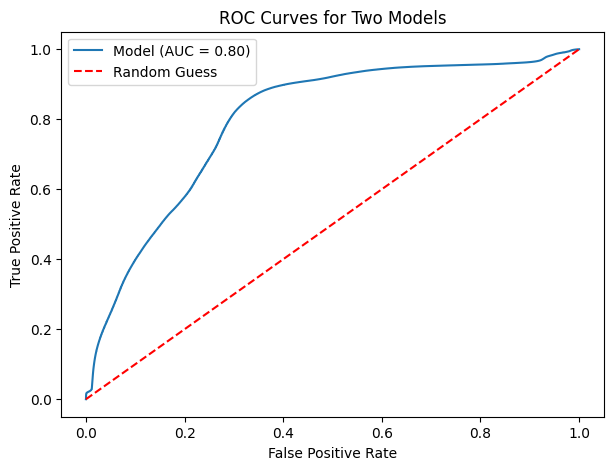

In [24]:
test_df = pd.DataFrame(
    {'True': y_test_np, 'Model': y_prob_in})

plt.figure(figsize=(7, 5))


fpr, tpr, _ = roc_curve(test_df['True'], test_df['Model'])
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'Model (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'r--', label='Random Guess')

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Two Models')
plt.legend()
plt.show()

In [25]:


y_true = np.array([int(label) for label in y_test_np])  # true labels
y_pred = prediction_in                         # predicted class labels (e.g., from predict_batch)

# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='macro')  # Use 'binary' if binary task
recall = recall_score(y_true, y_pred, average='macro')
f1 = f1_score(y_true, y_pred, average='macro')

# Overall Accuracy (OA)
oa = accuracy_score(y_true, y_pred)

# Average Accuracy (AA) — mean of per-class accuracies
cm = confusion_matrix(y_true, y_pred)
per_class_acc = cm.diagonal() / cm.sum(axis=1)
aa = per_class_acc.mean()

# Print all metrics
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"OA:        {oa:.4f}")
print(f"AA:        {aa:.4f}")

Precision: 0.5734
Recall:    0.6159
F1 Score:  0.5877
OA:        0.9060
AA:        0.6159


In [26]:
performance = {
    'AUC': float(roc_auc),
    'precision': float(precision),
    'recall': float(recall),
    'F1 Score': float(f1),
    'OA': float(oa),
    'AA': float(aa),
}
result_json = {
    'prediction' : scores,
    'performance' : performance,
}

In [27]:
# timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
print(result_json)

with open(f"performance/HybridSN {timestamp}_results.json", "w") as f:
    json.dump(result_json, f, indent=2)

print("JSON saved to results.json")

{'prediction': [{'dataset': 0, 'class0_size': 820876, 'class1_size': 29336, 'correct_0': 812733, 'correct_1': 11953, 'correct_total': 824686, 'total': 850212}, {'dataset': 1, 'class0_size': 1236269, 'class1_size': 12145, 'correct_0': 827101, 'correct_1': 12056, 'correct_total': 839157, 'total': 1248414}, {'dataset': 2, 'class0_size': 916980, 'class1_size': 39360, 'correct_0': 872556, 'correct_1': 33511, 'correct_total': 906067, 'total': 956340}, {'dataset': 3, 'class0_size': 959167, 'class1_size': 31849, 'correct_0': 826702, 'correct_1': 25207, 'correct_total': 851909, 'total': 991016}, {'dataset': 4, 'class0_size': 1363408, 'class1_size': 58562, 'correct_0': 1341606, 'correct_1': 32595, 'correct_total': 1374201, 'total': 1421970}, {'dataset': 5, 'class0_size': 1389552, 'class1_size': 53256, 'correct_0': 1376318, 'correct_1': 20260, 'correct_total': 1396578, 'total': 1442808}, {'dataset': 6, 'class0_size': 873365, 'class1_size': 93415, 'correct_0': 873232, 'correct_1': 2837, 'correct_t

In [28]:
end_time = time.time()
print(f"Run time: {end_time - start_time:.4f} seconds")

print(timestamp)
print(f"seet used: {seed}")

Run time: 2453.8054 seconds
20250610_171731
seet used: 10
